In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
# import data
data_path ="C:\\Users\\debas\\Uber demand Prediction/Data/location_data.csv"

df_reader = pd.read_csv(data_path,chunksize = 100000)

df_reader

In [25]:
# do sampling 
all_samples = []

df_reader = pd.read_csv(data_path,chunksize = 100000)

for df in df_reader:
    all_samples.append(df.sample(500))

sample_df = pd.concat(all_samples,axis = 0)

In [26]:
sample_df.shape

(166500, 2)

In [27]:
sample_df

,pickup_latitude,pickup_longitude
73442,40.748581,-73.994583
8928,40.731182,-73.988914
95748,40.730766,-73.988716
92228,40.742599,-74.004219
22712,40.756977,-73.989120
...,...,...
33224645,40.751213,-73.982597
33206557,40.643375,-73.789604
33217942,40.727566,-73.993362
33207417,40.719601,-73.994614


Text(0, 0.5, 'Longitude')

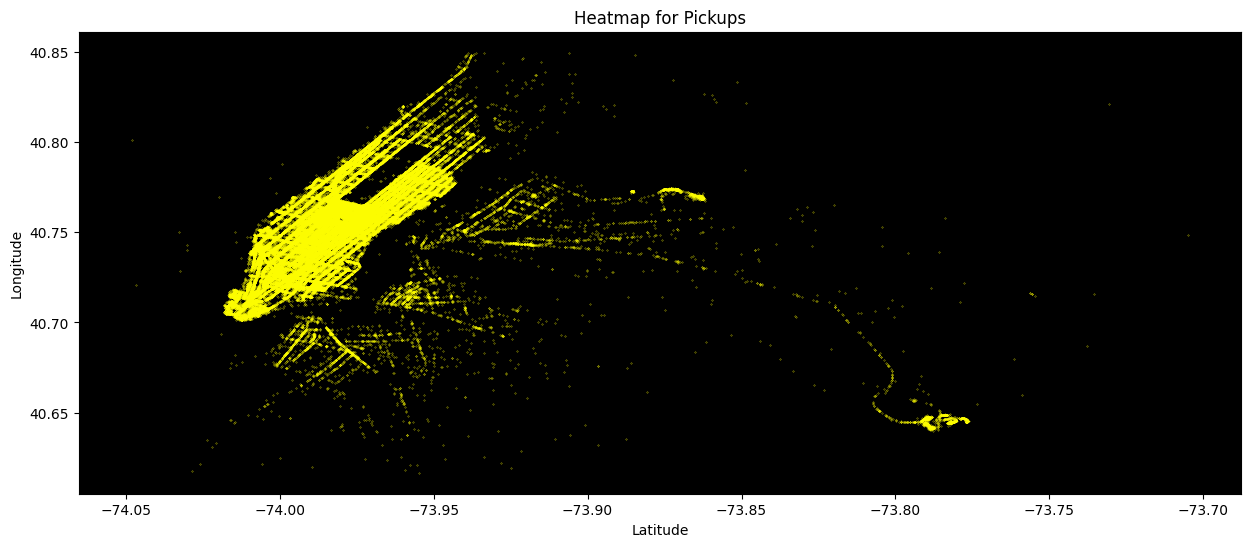

In [28]:
# plot the data set on a scatter plot

fig,ax = plt.subplots(nrows = 1,ncols = 1,sharey = True,figsize = (15,6))

ax.set_facecolor('k')
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s = 0.05,color = 'yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [29]:
from sklearn import set_config

set_config(transform_output = 'pandas')

In [30]:
# scale the input columns 
from sklearn.preprocessing import StandardScaler

scale_samples = StandardScaler()

scaled_sample_df = scale_samples.fit_transform(sample_df)

In [31]:
scaled_sample_df

,pickup_latitude,pickup_longitude
73442,-0.093317,-0.558706
8928,-0.732571,-0.404160
95748,-0.747848,-0.398751
92228,-0.313082,-0.821413
22712,0.215168,-0.409776
...,...,...
33224645,0.003391,-0.231933
33206557,-3.958697,5.029706
33217942,-0.865440,-0.525425
33207417,-1.158087,-0.559538


Text(0, 0.5, 'Longitude')

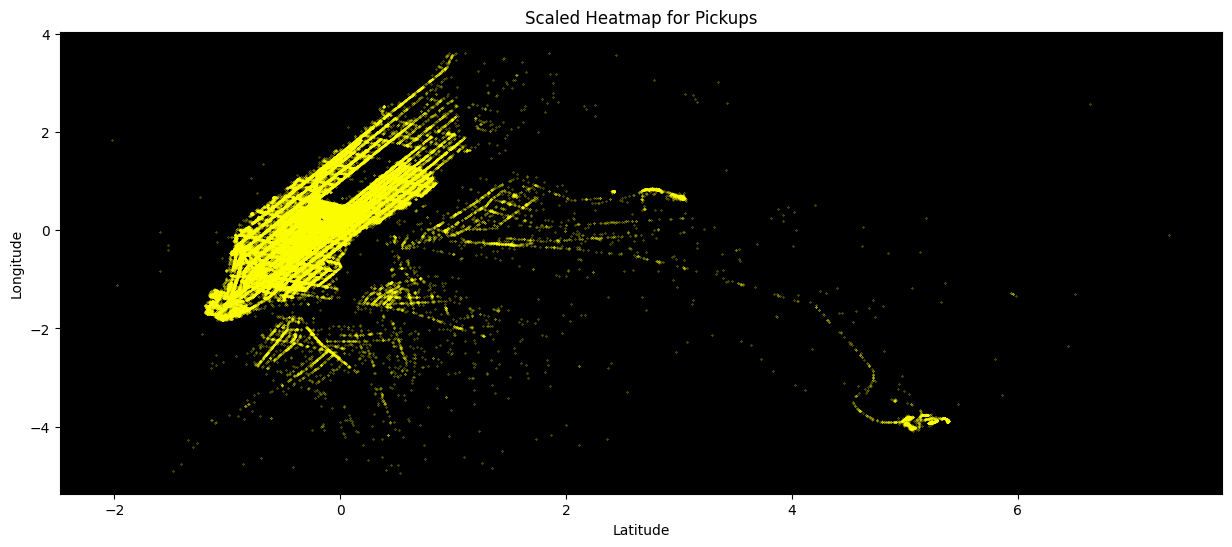

In [32]:

fig,ax = plt.subplots(nrows = 1,ncols = 1,sharey = True,figsize = (15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s = 0.05,color = 'yellow')
ax.set_title('Scaled Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [33]:
fig.savefig("graph.png", dpi=300, bbox_inches="tight")

In [34]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [35]:
df_reader = pd.read_csv(data_path,chunksize = 100000)

In [36]:
# train the standard scaler 
scaler = StandardScaler()

for chunk in df_reader :
    # fit the scaler 
    scaler.partial_fit(chunk)

In [37]:
scaler

StandardScaler()

In [38]:
# get the scaler mean and std

print("The mean of the data are ",scaler.mean_)
print("The sigma of the data are",scaler.scale_)

The mean of the data are  [ 40.75107121 -73.9740618 ]
The sigma of the data are [0.02722268 0.03675237]


In [39]:
def haversine_distance(lat1:float,lon1:float,lat2:float,lon2:float):
    """
    calculate the haversine distance between two points given their latitude and longitude coordinates
    """
    lon1,lat1,lon2,lat2 = map(np.radians,[lon1,lat1,lon2,lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    earth_radius = 3958.8
    distance = earth_radius * c
    return distance



In [46]:
def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
        
        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)
            
        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

In [42]:
possible_k_values = np.arange(10,100,10)

possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [48]:
# select the optimum value of k

select_optimum_k(k_values = possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 6 and is 30.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 9 and is 30.0% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 7 and is 14.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 10 and is 16.7% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 13 and is 18.6% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 14 and is 17.5% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 17 and is 18.9% regions of total


In [49]:
# Clustering
df_reader = pd.read_csv(data_path,chunksize = 100000)

In [50]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters = 30,n_init = 10,random_state = 42)

for chunks in df_reader:
    #scale the chunks
    scaled_chunk = scaler.transform(chunk)
    #train the model 
    mini_batch.partial_fit(scaled_chunk)

In [51]:
mini_batch

MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

In [52]:
# centroids of the model

mini_batch.cluster_centers_

array([[-0.26254721, -0.1875104 ],
       [-3.86798055,  5.1688827 ],
       [ 0.71846691,  0.44283504],
       [ 0.76389741,  2.84137411],
       [-1.13534315, -0.44390529],
       [ 0.29882657, -0.4410658 ],
       [-0.70271295, -0.76130582],
       [-2.89854561,  0.0159009 ],
       [ 2.53376815,  0.71256028],
       [ 0.44252595,  0.03427718],
       [ 1.41873873,  0.01025434],
       [-0.08640019, -0.44156035],
       [-1.2834212 ,  0.49448424],
       [ 0.88064006, -0.2174966 ],
       [-0.80491412, -0.30370324],
       [ 0.17544994,  1.29025049],
       [ 0.01639024, -0.06881021],
       [-1.61858643, -0.97218853],
       [-0.38700541, -0.79634631],
       [ 1.12224648,  0.58083464],
       [-1.18101205, -0.89971182],
       [-2.23039543, -0.29846536],
       [-0.93897155, -0.58607168],
       [ 0.51774881, -0.25271018],
       [-0.4526827 , -0.39724873],
       [ 0.238795  ,  0.17209588],
       [-2.08420075,  0.9489503 ],
       [ 0.25660484, -0.1489846 ],
       [-0.10021383,

In [53]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.74392397, -73.98095325],
       [ 40.64577443, -73.78409311],
       [ 40.7706298 , -73.95778657],
       [ 40.77186654, -73.86963457],
       [ 40.72016413, -73.99037637],
       [ 40.75920607, -73.99027202],
       [ 40.73194149, -74.0020416 ],
       [ 40.67216505, -73.97347741],
       [ 40.82004716, -73.94787352],
       [ 40.76311795, -73.97280204],
       [ 40.78969308, -73.97368493],
       [ 40.74871917, -73.99029019],
       [ 40.71613305, -73.95588834],
       [ 40.77504459, -73.98205532],
       [ 40.7291593 , -73.98522362],
       [ 40.75584743, -73.92664204],
       [ 40.7515174 , -73.97659074],
       [ 40.70700896, -74.00979204],
       [ 40.74053589, -74.00332942],
       [ 40.78162176, -73.95271475],
       [ 40.7189209 , -74.00712834],
       [ 40.69035388, -73.98503111],
       [ 40.72550989, -73.99560133],
       [ 40.76516572, -73.9833495 ],
       [ 40.73874798, -73.98866163],
       [ 40.75757185, -73.96773687],
       [ 40.69433369, -73.93918563],
 

In [54]:
# perform predictions and assign clusters
sample_predictions = mini_batch.predict(scaled_sample_df)
sample_predictions.shape

(166500,)

In [55]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

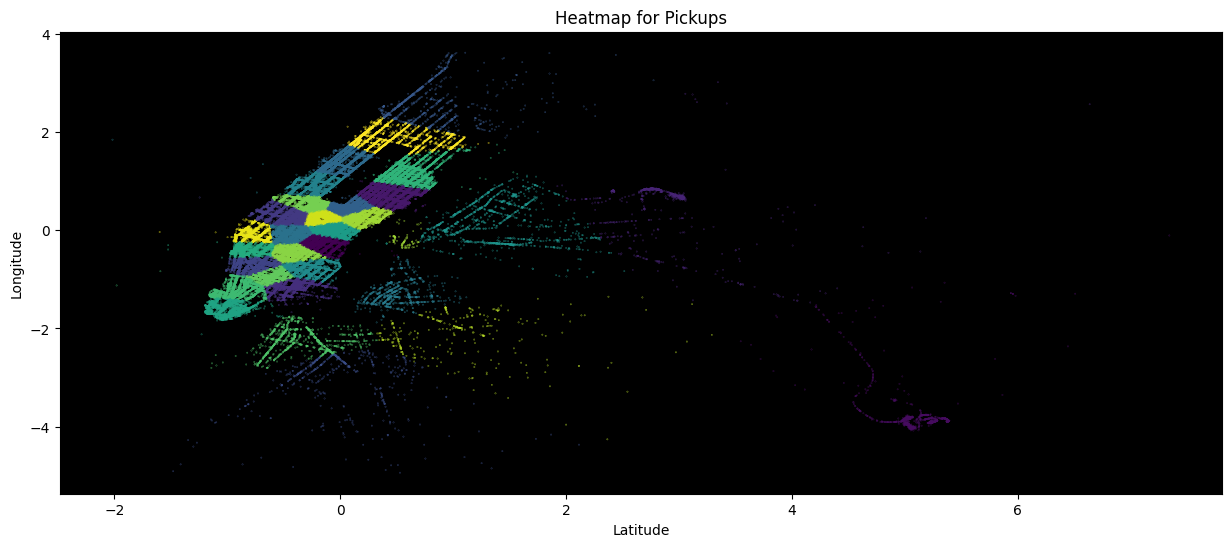

In [57]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows = 1,ncols = 1,sharey = True,figsize = (15,6))
ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s = 0.05,c = sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()